 Estimators[ Done-ish]

 * Birthday Problem Lowerbound Estimator [Done]
 * Database Literature Estimators
   * Goodmanâ€™s Estimator [done]
   * Chao Estimator [done]
   * Jackknife Estimator [done]
 * Statistical Literature Estimators
   * Chao and Lee Estimators [done]
   * Shlosserâ€™s Estimator [need to read Shlosser's paper to implement determination of q properly]
   * Sichel's Parameteric Estimator [done but can be optimised further]
   * Moment of Moments Estimator [done but can be optimised further]
   * Bootstrap Estimator [done]
 * New Estimators
   * Horvitz-Thompson Estimator [done]
   * Method-of-Moments Estimators Novel [done]
   * A Smoothed Jackknife Estimator [done]
 * Machine Learned Estimators
   *

# Refactoring [Done]
 # mathematical verification [not done]

 # Optimisation [not done]




In [1]:
import logging

logger = logging.getLogger()
import numpy as np

np.random.seed(42)

In [26]:
# Sampling functions - generate a sample sequence of values from a distribution function

def sample_uniform(n_distinct_integers=1000, sample_size=500, seed=None):
    """
    generate a sample sequence of integers from a uniform distribution of n distinct integers

    :param n_distinct_integers: N number of distinct integers to generate sample from
    :type n_distinct_integers: int
    :param sample_size: sample size
    :type sample_size: int
    :returns : dictionary with sampled sequence[sample],
                               actual number of distinct values[ground_truth],
                               sample number of distinct values[sample_distinct]
    """
    
    sample = np.random.randint(1, n_distinct_integers, sample_size)

    return {"sample": sample, "sample_distinct": len(set(sample)), "ground_truth": n_distinct_integers}


def sample_gaussian(cov=200.0, population_size=1000, sample_size=500):
    '''
    generate a ground truth population of distinct integers from a gaussian distribution (rounded to nearest int),
    then draw a sample sequence of integers without replacement from the population. Integers created could be negative

    :param cov: covariance of gaussian distribution
    :type cov: float
    :param population_size: ground truth number of distinct integers in population, with different probabilities
    :type population_size: int
    :param sample_size: sample size of sequence observed
    :type sample_size: int
    :returns : dictionary with sampled sequence[sample],
                               actual number of distinct values[ground_truth],
                               sample number of distinct values[sample_distinct]
    '''

    population = [int(i) for i in np.random.normal(0, cov, population_size)]  # set mean as 0, doesn't really matter

    sample = population[:sample_size]

    return {"sample": sample, "sample_distinct": len(set(sample)), "ground_truth": len(set(population))}


def sample_zipf(alpha=1.3, population_size=1000, sample_size=500):
    """
    generate a population of distinct integers from a zipf distribution (ground truth) as characterised by zipf(alpha,n),
    then draw a sample a sequence of integers from the population.

    :param alpha: alpha parameter of zipf distribution
    :type alpha: float
    :param population_size: the ground truth population size
    :type population_size: int
    :param sample_size: sample size of sequence observed
    :type sample_size: int
    :returns : dictionary with sampled sequence[sample],
                               actual number of distinct values[ground_truth],
                               sample number of distinct values[sample_distinct]
    """

    population = [int(i) for i in np.random.zipf(alpha, size=population_size)]

    sample = population[:sample_size]

    return {"sample": sample, "sample_distinct": len(set(sample)), "ground_truth": len(set(population))}

In [27]:
print("gaussian", sample_gaussian())
print("uniform", sample_uniform())
print("zipf", sample_zipf())

gaussian {'sample': [279, 184, 11, -129, 139, 78, 179, 127, 209, -107, 263, 39, 415, -137, 347, 39, -130, -96, -64, 84, 104, -114, -4, 428, 345, 87, 7, 24, 122, -204, -51, -333, 79, 129, -96, 314, -245, -292, 44, 209, 336, -91, 215, -7, -34, 176, 130, -315, 295, 276, -125, 79, 98, 52, -110, -134, -5, 234, 108, -74, 154, -569, 229, -347, -72, -223, -258, 232, -93, 69, -9, 95, 15, -256, 199, -98, -311, -85, 300, 170, -69, -69, -64, 415, 76, 86, 206, 47, -51, -39, -14, -7, 145, 10, 146, -16, 15, -399, 183, 69, 199, -579, 417, -27, 221, -207, 122, -210, -124, 382, -38, 43, 174, 99, 30, 72, 480, -11, 40, 210, 221, 237, 127, -228, 326, -229, 60, -150, -12, 65, 64, 84, 322, 90, -48, 192, 237, -245, 119, 140, -59, 275, -30, 25, -34, 3, -219, -288, 318, -169, -198, -430, -127, -264, 328, 201, -137, 450, 196, -64, -499, 458, -277, -329, 204, 487, 276, 112, 118, 170, 151, 56, 20, -12, -150, -56, -338, -19, -197, -220, 35, 278, 183, -314, -197, 188, -196, -44, 110, -193, 21, -266, -120, 63, -318, 

In [28]:
def test_func(func, sequence, ground_truth, verbose=False, n_trials=100, params={}):
    """
    run estimator with a sequence for n trials and compares results with ground truth. Catches estimator errors if invalid

    :param func: estimator to be tested
    :type func: estimator function, takes in a sequence, returns a number (estimated distinct count)
    :param sequence: sequence of values observed
    :type sequence: array of ints
    :param ground_truth: actual number of distinct relations in population
    :type ground_truth: int
    :param verbose: Flag for verbosity of function
    :type verbose: boolean
    :param n_trials: number of trials to compute estimator, particularly important if random initialisation involved
    :type n_trials: int
    :param params: extra parameters to the estimator function
    :type params: dictionary
    :return: Prints results of tests
    :rtype: None
    """

    absolute_errors, percentage_errors, invalid_results_set, estimates = [], [], [], []
    invalid_count = 0
    for i in range(n_trials):  # n number of trials trials
        try:
            estimate = func(sequence, **params)
            estimates.append(estimate)
            absolute_errors.append(abs(estimate - ground_truth))
            percentage_errors.append(abs(estimate - ground_truth) / ground_truth)
        except Exception as e:
            if verbose:
                print("exception found :", e)
            invalid_count += 1
            invalid_results_set.append(e)
    print("average guess :", np.mean(estimates))
    print("overall absolute errors :", np.mean(np.nan_to_num(absolute_errors)))
    print("overall percentage errors :", np.mean(np.nan_to_num(percentage_errors)))
    print("invalid results observed :", invalid_count)
    print("errors are :", invalid_results_set)

In [29]:
def default_test_set(func, params={}):
    """
    test function to quickly test any function using default parameters for different skew types

    :param func: estimator to be tested
    :type func: estimator function, takes in a sequence, returns a number (estimated distinct count)
    :param params:
    :type params:
    :return: Prints results of tests
    :rtype: None
    """
    print("normally distributed population")
    test = sample_uniform()
    print("true distinct :", test["ground_truth"], ", sample distinct :", test["sample_distinct"])
    test_func(func, sequence=test["sample"], ground_truth=test["ground_truth"], n_trials=10, params=params)
    print("gaussian distributed population")
    test = sample_gaussian()
    print("true distinct :", test["ground_truth"], ", sample distinct :", test["sample_distinct"])
    test_func(func, sequence=test["sample"], ground_truth=test["ground_truth"], n_trials=10, params=params)
    print("zipf distributed population")
    test = sample_zipf()
    print("true distinct :", test["ground_truth"], ", sample distinct :", test["sample_distinct"])
    test_func(func, sequence=test["sample"], ground_truth=test["ground_truth"], n_trials=10, params=params)

In [30]:
default_test_set(lambda x: len(set(x)))

normally distributed population
true distinct : 1000 , sample distinct : 396
average guess : 396.0
overall absolute errors : 604.0
overall percentage errors : 0.604
invalid results observed : 0
errors are : []
gaussian distributed population
true distinct : 539 , sample distinct : 347
average guess : 347.0
overall absolute errors : 192.0
overall percentage errors : 0.3562152133580705
invalid results observed : 0
errors are : []
zipf distributed population
true distinct : 277 , sample distinct : 177
average guess : 177.0
overall absolute errors : 100.0
overall percentage errors : 0.3610108303249097
invalid results observed : 0
errors are : []


In [31]:
def compute_birthday_problem_probability(sequence, lower_bound_probability=0.1):
    """

    Suppose we draw N samples and all are distinct values. We can compute the probability of this event happening
    (N unique values in N draws) for specific R number of distinct values within a population, this helps us put a
    bound on the estimated number of distinct values.
    We estimate the number of distinct values as the population number where there is a 10% chance
    that these N distinct draws could happened due to random chance alone

    #could be optimised somehow
    
    :param sequence: observed sequence of integers
    :type sequence: list of int
    :param lower_bound_probability: lower bound probability for such an event happening by random chance
    :type lower_bound_probability: float (0 to 1)
    :return: estimated lower bound for distinct number of integers 
    :rtype: int 
    """
    logger.warning(
        "Using collision probability to compute lower bound of distinct count ie min(n) for which P(n) > 0.01")
    d = len(set(sequence))
    i = d
    while True:  # try different lower bounds
        lower_bound = d + i
        multiplied = 1
        for j in range(d):
            multiplied *= (lower_bound - j) / lower_bound
        if multiplied > lower_bound_probability:
            break
        i += 1
    return lower_bound

In [32]:
print(compute_birthday_problem_probability(list(i for i in range(10)),lower_bound_probability=0.1)) # 10% by 
print(compute_birthday_problem_probability(list(i for i in range(10)),lower_bound_probability=0.5))
print(compute_birthday_problem_probability(list(i for i in range(10)),lower_bound_probability=0.9))

23
69
431


In [33]:
def _get_attribute_counts(sequence):
    """
    counts each unique attribute in a sequence

    :param sequence: observed sequence of integers
    :type sequence: list of int
    :return: dictionary with keys as attributes and values as counts of these attributes
    :rtype: dictionary (str -> int)
    """
    from itertools import groupby

    attribute_counts = {}
    for key, group in groupby(sorted(sequence), key=lambda x: x):
        attribute_counts[key] = len(list(group))

    return attribute_counts


def _get_frequency_dictionary(sequence):
    """
    counts the frequency of attributes (group by count)

    :param sequence: observed sequence of integers
    :type sequence: list of int
    :return: dictionary with keys as frequencies and values as counts of these frequency
    :rtype: dict
    """
    from itertools import groupby

    attribute_counts = _get_attribute_counts(sequence)

    frequency_dictionary = {}
    for key, group in groupby(sorted(attribute_counts.items(), key=lambda x: x[1]), key=lambda x: x[1]):
        frequency_dictionary[key] = len(list(group))

    return frequency_dictionary

In [34]:
def goodmans_estimator(sequence):
    """

    throws an error if N is too high due to numerical complexity

    :param sequence: sample sequence of integers
    :type sequence: array of ints
    :return: estimated distinct count
    :rtype: int
    """
    n = len(sequence)
    d_n = len(set(sequence))
    N = n * 2
    frequency_dictionary = _get_frequency_dictionary(sequence)

    memo_fact_dict = {}

    def memo_fact(x, memo_dict):
        if x not in memo_dict:
            memo_dict[x] = np.math.factorial(x)
        return memo_dict[x], memo_dict

    sum_goodman = 0
    for i in frequency_dictionary.keys():
        num_1, memo_fact_dict = memo_fact(N - n + i - 1, memo_fact_dict)
        num_2, memo_fact_dict = memo_fact(n - i, memo_fact_dict)
        denom_1, memo_fact_dict = memo_fact(N - n - 1, memo_fact_dict)
        denom_2, memo_fact_dict = memo_fact(n, memo_fact_dict)
        sum_goodman += ((-1) ** (i + 1)) * num_1 * num_2 * frequency_dictionary[i] / (denom_1 * denom_2)
    d_goodman = d_n + sum_goodman
    return d_goodman

In [35]:
default_test_set(goodmans_estimator)

normally distributed population
true distinct : 1000 , sample distinct : 404
average guess : 655.7514044840791
overall absolute errors : 344.2485955159209
overall percentage errors : 0.3442485955159209
invalid results observed : 0
errors are : []
gaussian distributed population
true distinct : 565 , sample distinct : 371
average guess : 567.6934278680183
overall absolute errors : 2.6934278680182615
overall percentage errors : 0.0047671289699438265
invalid results observed : 0
errors are : []
zipf distributed population
true distinct : 276 , sample distinct : 164
average guess : -541527863405113.3
overall absolute errors : 541527863405389.3
overall percentage errors : 1962057476106.4832
invalid results observed : 0
errors are : []


In [36]:
def chao_estimator(sequence):
    """
    d_chao = d + f1^2/(2f2)
    returns birthday problem solution if there are no sequences observed of frequency 2 (ie each distinct value observed is never seen again)
        
    also makes insane bets (10x) when every point observed is almost unique. could be good or bad

    :param sequence: sample sequence of integers
    :type sequence: array of ints
    :return: estimated distinct count
    :rtype: int
    """

    frequency_dictionary = _get_frequency_dictionary(sequence)
    f1 = frequency_dictionary[1]
    
    if 2 not in frequency_dictionary:
        logger.warning("f2 frequency is 0, Chao estimator returns infinite results")
        return compute_birthday_problem_probability(sequence)
    
    f2 = frequency_dictionary[2]
    d_chao = len(set(sequence)) + np.square(f1) / (2 * f2)

    return d_chao

In [37]:
logger.setLevel("CRITICAL")
default_test_set(chao_estimator)

normally distributed population
true distinct : 1000 , sample distinct : 398
average guess : 1200.5714285714282
overall absolute errors : 200.57142857142844
overall percentage errors : 0.20057142857142846
invalid results observed : 0
errors are : []
gaussian distributed population
true distinct : 554 , sample distinct : 368
average guess : 770.1453488372092
overall absolute errors : 216.14534883720935
overall percentage errors : 0.390154059272941
invalid results observed : 0
errors are : []
zipf distributed population
true distinct : 256 , sample distinct : 152
average guess : 753.1363636363637
overall absolute errors : 497.1363636363637
overall percentage errors : 1.9419389204545456
invalid results observed : 0
errors are : []


In [38]:
def jackknife_estimator(sequence):
    """
    D^hat_c_j = d_n - (n - l)(d_(n-1)- d_n).
    need to double check

    #good at regimes where sample size is close to actual number of points

    :param sequence: sample sequence of integers
    :type sequence: array of ints
    :return: estimated distinct count
    :rtype: int
    """

    n = len(sequence)
    d_n = len(set(sequence))
    attribute_counts = _get_attribute_counts(sequence)

    sum_d_n_minus_1 = 0
    for i in range(n):
        tuple_k = sequence[i]
        if attribute_counts[tuple_k] == 1:
            sum_d_n_minus_1 += d_n - 1
        else:
            sum_d_n_minus_1 += d_n
    d_n_minus_1 = sum_d_n_minus_1 / n

    d_jackknife = d_n - (n - 1) * (d_n_minus_1 - d_n)

    return d_jackknife

In [39]:
default_test_set(jackknife_estimator)

normally distributed population
true distinct : 1000 , sample distinct : 389
average guess : 688.4000000000113
overall absolute errors : 311.59999999998865
overall percentage errors : 0.31159999999998866
invalid results observed : 0
errors are : []
gaussian distributed population
true distinct : 569 , sample distinct : 364
average guess : 624.4779999999957
overall absolute errors : 55.477999999995745
overall percentage errors : 0.09750087873461466
invalid results observed : 0
errors are : []
zipf distributed population
true distinct : 297 , sample distinct : 166
average guess : 295.7399999999954
overall absolute errors : 1.2600000000045384
overall percentage errors : 0.004242424242439523
invalid results observed : 0
errors are : []


In [40]:
def chao_lee_estimator(sequence):
    """
    gamma hat is an estimator for the squared coefficient of variation of the frequencies
    
    #check the gamma estimator 
    
    :param sequence: sample sequence of integers
    :type sequence: array of ints
    :return: estimated distinct count
    :rtype: int
    """
    n = len(sequence)
    d = len(set(sequence))
    frequency_dictionary = _get_frequency_dictionary(sequence)
    f1 = frequency_dictionary[1]
    attribute_counts = _get_attribute_counts(sequence)

    try:
        c_hat = 1 - f1 / n  # throws an error if f1 = n (all values observed are unique.)
    except:
        logger.warning("all values observed are unique, using birthday problem approach")
        return compute_birthday_problem_probability(sequence)
    gamma_hat_squared = (1 / d) * np.var(list(attribute_counts.values())) / ((n / d) ** 2)

    d_cl = d / c_hat + n * (1 - c_hat) * gamma_hat_squared / c_hat

    return d_cl

In [17]:
default_test_set(chao_lee_estimator)

normally distributed population


TypeError: randint() got an unexpected keyword argument 'seed'

In [18]:
def shlossers_estimator(sequence, pop_estimator=lambda x: x * 2, n_pop=None):
    """

    Hard to determine q (probability of being included)

    @KengHwee

    :param sequence: sample sequence of integers
    :type sequence: array of ints
    :return: estimated distinct count
    :rtype: int
    """
    n = len(sequence)
    d = len(set(sequence))

    frequency_dictionary = _get_frequency_dictionary(sequence)
    if not n_pop:
        n_pop = pop_estimator(n)
        
    f1 = frequency_dictionary[1]
    q = n / n_pop  # placeholder q determination - TODO
    numerator = 0
    denominator = 0
    for i in range(1, n):
        if i in frequency_dictionary:
            result = frequency_dictionary[i]
        else:
            result = 0
        numerator += ((1 - q) ** i) * result
        denominator += (i * q * (1 - q) ** (i - 1)) * result

    d_shlosser = d + f1 * numerator / denominator
    return d_shlosser

In [19]:
default_test_set(shlossers_estimator)

normally distributed population


TypeError: randint() got an unexpected keyword argument 'seed'

In [20]:
import warnings

from scipy.optimize import broyden1, broyden2

def sichel_estimator(sequence):
    """
    could change solution finding method, currently using newton raphson method
    can be optimised (training rate, stopping value)
    
    use broyden 1 to solve, search linear space for good solution

    :param sequence: sample sequence of integers
    :type sequence: array of ints
    :return: estimated distinct count
    :rtype: int
    """
    n = len(sequence)
    d = len(set(sequence))

    frequency_dictionary = _get_frequency_dictionary(sequence)

    f1 = frequency_dictionary[1]
    A = ((2 * n) / d ) - np.log(n / f1)  # does not depend on g
    B = ((2 * f1) / d ) + np.log(n / f1)  # does not depend on g

    training_rate = 0.00001
    
    def y(g):
        result = (1+g)*np.log(g) - A*g + B
        return result
    
    d_sichel_set = set()
    
    for value in np.linspace((f1/n)+0.00001,0.999999,20):
        g = 0
        try :
            g = broyden1(y,value)
            if g > f1/n and g < 1 and ((n * g) / f1) > 0:
                b_hat = g * np.log((n * g) / f1) / (1 - g)
                c_hat = (1 - g ** 2) / (n * (g ** 2))
                d_sichel = 2 / (b_hat * c_hat)
                d_sichel_set.add(d_sichel)
        except :
            continue
    for value in np.linspace((f1/n)+0.00001,0.999999,20):
        g = 0
        try :
            g = broyden2(y,value)
            if g > f1/n and g < 1 and ((n * g) / f1) > 0:
                b_hat = g * np.log((n * g) / f1) / (1 - g)
                c_hat = (1 - g ** 2) / (n * (g ** 2))
                d_sichel = 2 / (b_hat * c_hat)
                d_sichel_set.add(d_sichel)
        except :
            continue
    if not d_sichel_set :
        return 0
    else :
        return min(d_sichel_set)
    

In [21]:
warnings.filterwarnings('ignore') 
default_test_set(sichel_estimator)
warnings.filterwarnings('default')

normally distributed population


TypeError: randint() got an unexpected keyword argument 'seed'

In [22]:
def method_of_moments_estimator(sequence):
    """
    can be optimised (training rate, stopping value)

    d = d_moments(l -  e^(-n))/d_moments)

    solve for d_moments in d = d_moments(l -  e^(-n))/d_moments)

        d/d_moments = 1 -e^(-n))/d_moments
        d(d)/d(d_moments) = 1*(-e^(-n/d_moments)) + d_moments((1/d_moments^2)*e(-n/d_moments))
        f(g) = (1+g)ln(g) - Ag + B
        guess g as  g = (f1/n + 1) / 2
        next_g = g - f(g)/f'(g)


    :param sequence: sample sequence of integers
    :type sequence: array of ints
    :return: estimated distinct count
    :rtype: int
    """
    n = len(sequence)
    d = len(set(sequence))
    
    def Y(D):
        return D*(1- np.exp((-n / D))) - d
    
    d_moments = broyden1(Y,d)

    return d_moments

In [23]:
default_test_set(method_of_moments_estimator)

normally distributed population


TypeError: randint() got an unexpected keyword argument 'seed'

In [24]:
def bootstrap_estimator(sequence):
    """
        DBoot = d + sigma (1-nj/n)^n

    :param sequence: sample sequence of integers
    :type sequence: array of ints
    :return: estimated distinct count
    :rtype: int
    """
    n = len(sequence)
    d = len(set(sequence))

    attribute_counts = _get_attribute_counts(sequence)
    bootstrap_sum = 0
    for j, n_j in attribute_counts.items():
        final_val = (1 - n_j / n) ** n
        bootstrap_sum += final_val
    d_bootstrap = d + bootstrap_sum
    return d_bootstrap

In [25]:
default_test_set(bootstrap_estimator)

normally distributed population


TypeError: randint() got an unexpected keyword argument 'seed'

In [60]:

import math


def memoized_gamma(x, memo_dict):
    """
    standard implementation of the gamma function

    :param x:value to evaluate gamma function at
    :type x: float
    :param memo_dict: memoized dictionary for precomputed gamma values
    :type memo_dict: dict
    :return: value of gamma function evaluated at x, and memoized results
    :rtype: int, dict
    """
    x = int(x)
    if x in memo_dict:
        return memo_dict[x], memo_dict
    else:
        result = math.lgamma(x)
        memo_dict[x] = result
        return result, memo_dict


def memoized_h_x(x, n, n_pop, memo_dict):
    """
    used in horvitz, method of moments (v1 and v2) and the smoothed jackknife estimators

    @KengHwee

    :param x:  h function evaluated at point x
    :type x: int
    :param n: length of sequence seen
    :type n: int
    :param n_pop: estimate of total number of tuples in Relation
    :type n_pop: int
    :param memo_dict: dictionary where gamma functions results are saved
    :type memo_dict: dict
    :return: value of h function evaluated at x, and memoized results
    :rtype: float, dict
    """

    gamma_num_1, memo_dict = memoized_gamma(n_pop - x + 1, memo_dict)
    gamma_num_2, memo_dict = memoized_gamma(n_pop - n + 1, memo_dict)
    gamma_denom_1, memo_dict = memoized_gamma(n_pop - x - n + 1, memo_dict)
    gamma_denom_2, memo_dict = memoized_gamma(n_pop + 1, memo_dict)

    result = np.exp(gamma_num_1 + gamma_num_2 - gamma_denom_1 - gamma_denom_2)
    return result, memo_dict


def h_x(x, n, n_pop):
    """
    used in horvitz, method of moments (v1 and v2) and the smoothed jackknife estimators

    :param x: h function evaluated at point x
    :type x: int
    :param n: length of sequence seen
    :type n: int
    :param n_pop: estimate of total number of tuples in Relation
    :type n_pop: int
    :return: value of h function evaluated at x
    :rtype: float
    """

    gamma_num_1, memo_dict = memoized_gamma(n_pop - x + 1, {})
    gamma_num_2, memo_dict = memoized_gamma(n_pop - n + 1, memo_dict)
    gamma_denom_1, memo_dict = memoized_gamma(n_pop - x - n + 1, memo_dict)
    gamma_denom_2, memo_dict = memoized_gamma(n_pop + 1, memo_dict)

    result = np.exp(gamma_num_1 + gamma_num_2 - gamma_denom_1 - gamma_denom_2)
    return result

In [61]:
def horvitz_thompson_estimator(sequence, pop_estimator=lambda x: x * 10000000, n_pop=None):
    """
    n = length of sequence
    n_j = attribute count of value j

    :param sequence: sample sequence of integers
    :type sequence: array of ints
    :param pop_estimator: function to estimate population size if possible
    :type pop_estimator: function that takes in the length of sequence (int) and outputs 
                         the estimated population size (int)
    :param n_pop: estimate of population size if available, will be used over pop_estimator function
    :type n_pop: int
    :return: estimated distinct count
    :rtype: int
    """

    n = len(sequence)
    if not n_pop:
        n_pop = pop_estimator(n)
    attribute_counts = _get_attribute_counts(sequence)

    d_horvitz_thompson = 0
    memo_dict_instance = {}
    for j, n_j in attribute_counts.items():
        n_j_hat = (n_j * n_pop) / n
        h_n_j_hat, memo_dict_instance = memoized_h_x(n_j_hat, n, n_pop, memo_dict_instance)
        d_horvitz_thompson += (1 / (1 - h_n_j_hat))

    return d_horvitz_thompson

In [62]:
for N_factor in [100, 1000, 10000, 100000, 1000000, 100000000]:
    print("n is", N_factor)
    default_test_set(horvitz_thompson_estimator, params={"pop_estimator": lambda x: x * N_factor})

n is 100
normally distributed population
true distinct : 1000 , sample distinct : 409
average guess : 610.4804463078069
overall absolute errors : 389.5195536921932
overall percentage errors : 0.38951955369219327
invalid results observed : 0
errors are : []
gaussian distributed population
true distinct : 572 , sample distinct : 373
average guess : 542.3833647735426
overall absolute errors : 29.616635226457447
overall percentage errors : 0.05177733431198854
invalid results observed : 0
errors are : []
zipf distributed population
true distinct : 265 , sample distinct : 157
average guess : 228.6523206409558
overall absolute errors : 36.34767935904415
overall percentage errors : 0.13716105418507227
invalid results observed : 0
errors are : []
n is 1000
normally distributed population
true distinct : 1000 , sample distinct : 398
average guess : 592.1128203110172
overall absolute errors : 407.8871796889829
overall percentage errors : 0.4078871796889828
invalid results observed : 0
errors are 

In [63]:
def method_of_moments_v2_estimator(sequence, pop_estimator=lambda x: x * 1000000, n_pop=None):
    """

    :param sequence: sample sequence of integers
    :type sequence: array of ints
    :param pop_estimator: function to estimate population size if possible
    :type pop_estimator: function that takes in the length of sequence (int) and outputs 
                         the estimated population size (int)
    :param n_pop: estimate of population size if available, will be used over pop_estimator function
    :type n_pop: int
    :return: estimated distinct count
    :rtype: int
    """
    n = len(sequence)
    if not n_pop:
        n_pop = pop_estimator(n)
    d = len(set(sequence))

    d_moments_v2 = d

    fin_diff = 0.05
    
    # need to implement gamma memoized function and h_x again here to enable use of global variables in broydens
    
    memo_dict = {}
    
    def memoized_gamma(x):
        """

        :param x:value to evaluate gamma function at
        :type x: float
        :param memo_dict: memoized dictionary for precomputed gamma values
        :type memo_dict: dict
        :return: value of gamma function evaluated at x, and memoized results
        :rtype: int, dict
        """
        x = int(x)
        if x in memo_dict:
            return memo_dict[x]
        else:
            result = math.lgamma(x)
            memo_dict[x] = result
            return result


    def h_x(x, n, n_pop):
        """

        :param x: h function evaluated at point x
        :type x: int
        :param n: length of sequence seen
        :type n: int
        :param n_pop: estimate of total number of tuples in Relation
        :type n_pop: int
        :return: value of h function evaluated at x
        :rtype: float
        """

        gamma_num_1 = memoized_gamma(n_pop - x + 1)
        gamma_num_2 = memoized_gamma(n_pop - n + 1)
        gamma_denom_1 = memoized_gamma(n_pop - x - n + 1)
        gamma_denom_2 = memoized_gamma(n_pop + 1)

        result = np.exp(gamma_num_1 + gamma_num_2 - gamma_denom_1 - gamma_denom_2)
        return result

    def Y(D):
        return D*(1- h_x((n_pop / D), n, n_pop)) - d
    
    d_moments = broyden1(Y, d)
    
    return d_moments

In [64]:
for N_factor in [100, 1000, 10000, 100000, 1000000, 100000000]:
    print("n is", N_factor)
    default_test_set(method_of_moments_v2_estimator, params={"pop_estimator": lambda x: x * N_factor})

n is 100
normally distributed population
true distinct : 1000 , sample distinct : 393
average guess : 937.9437065295193
overall absolute errors : 62.05629347048057
overall percentage errors : 0.06205629347048057
invalid results observed : 0
errors are : []
gaussian distributed population
true distinct : 572 , sample distinct : 366
average guess : 731.4148329581424
overall absolute errors : 159.41483295814237
overall percentage errors : 0.2786972604163328
invalid results observed : 0
errors are : []
zipf distributed population
true distinct : 271 , sample distinct : 152
average guess : 158.5541113756208
overall absolute errors : 112.4458886243792
overall percentage errors : 0.41492947831874244
invalid results observed : 0
errors are : []
n is 1000
normally distributed population
true distinct : 1000 , sample distinct : 403
average guess : 1107.387412146048
overall absolute errors : 107.38741214604784
overall percentage errors : 0.10738741214604783
invalid results observed : 0
errors are

C:\Users\User\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\User\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


average guess : nan
overall absolute errors : nan
overall percentage errors : nan
invalid results observed : 10
errors are : [NoConvergence(array(1062.72180395)), NoConvergence(array(1062.72180395)), NoConvergence(array(1062.72180395)), NoConvergence(array(1062.72180395)), NoConvergence(array(1062.72180395)), NoConvergence(array(1062.72180395)), NoConvergence(array(1062.72180395)), NoConvergence(array(1062.72180395)), NoConvergence(array(1062.72180395)), NoConvergence(array(1062.72180395))]
gaussian distributed population
true distinct : 551 , sample distinct : 367
average guess : 763.2643096405336
overall absolute errors : 212.2643096405336
overall percentage errors : 0.3852346817432552
invalid results observed : 0
errors are : []
zipf distributed population
true distinct : 248 , sample distinct : 145
average guess : 150.3446964648465
overall absolute errors : 97.65530353515351
overall percentage errors : 0.3937713852223932
invalid results observed : 0
errors are : []
n is 1000000
nor

In [65]:
method_of_moments_v2_estimator(sample_uniform())

array(2124.13502478)

In [66]:
def method_of_moments_v3_estimator(sequence, pop_estimator=lambda x: x * 10000000, n_pop=None):
    """

    :param sequence: sample sequence of integers
    :type sequence: array of ints
    :param pop_estimator: function to estimate population size if possible
    :type pop_estimator: function that takes in the length of sequence (int) and outputs 
                         the estimated population size (int)
    :param n_pop: estimate of population size if available, will be used over pop_estimator function
    :type n_pop: int
    :return: estimated distinct count
    :rtype: int
    """
    n = len(sequence)
    if not n_pop:
        n_pop = pop_estimator(n)
    d = len(set(sequence))

    attribute_counts = _get_attribute_counts(sequence)

    gamma_hat_squared = (1 / d) * np.var(list(attribute_counts.values())) / ((n_pop / d) ** 2)

    def compute_g_n(x, n, n_pop):
        """
        See implementation paper for details 
        
        :param x: g function evaluated at point x
        :type x: int
        :param n: length of sequence seen
        :type n: int
        :param n_pop: estimate of total number of tuples in relation
        :type n_pop: int
        :return: value of g function evaluated at x
        :rtype: float
        """
        return_sum = 0
        for k in range(n):
            return_sum += 1 / (n_pop - x - n + k)
        return return_sum

    d_mm_1 = method_of_moments_v2_estimator(sequence)
    n_pop_tilda = n_pop / d_mm_1
    d_mm_2_huge_term = 0.5 * (n_pop_tilda ** 2) * gamma_hat_squared * d_mm_1 * h_x(n_pop_tilda, n, n_pop) * (compute_g_n(n_pop_tilda, n, n_pop) - compute_g_n(n_pop_tilda, n, n_pop) ** 2)
    d_moments_v3 = d * (1 - h_x(n_pop_tilda, n, n_pop) + d_mm_2_huge_term) ** -1
    return d_moments_v3

In [67]:
default_test_set(method_of_moments_v3_estimator)

normally distributed population
true distinct : 1000 , sample distinct : 390
average guess : 961.1088920111918
overall absolute errors : 38.89110798880836
overall percentage errors : 0.038891107988808356
invalid results observed : 0
errors are : []
gaussian distributed population
true distinct : 561 , sample distinct : 361
average guess : 722.342789733146
overall absolute errors : 161.342789733146
overall percentage errors : 0.287598555674057
invalid results observed : 0
errors are : []
zipf distributed population
true distinct : 287 , sample distinct : 170
average guess : 181.4466371891733
overall absolute errors : 105.55336281082671
overall percentage errors : 0.3677817519541001
invalid results observed : 0
errors are : []


In [68]:
def smoothed_jackknife_estimator(sequence, pop_estimator=lambda x: x * 10000000, n_pop=None):
    """

    :param sequence: sample sequence of integers
    :type sequence: array of ints
    :param pop_estimator: function to estimate population size if possible
    :type pop_estimator: function that takes in the length of sequence (int) and outputs 
                         the estimated population size (int)
    :param n_pop: estimate of population size if available, will be used over pop_estimator function
    :type n_pop: int
    :return: estimated distinct count
    :rtype: int
    """
    n = len(sequence)
    if not n_pop:
        n_pop = pop_estimator(n)
    d = len(set(sequence))

    if d == len(sequence):
        logger.warning("all values seen were unique, reverting to inverse birthday problem solution")
        return compute_birthday_problem_probability(sequence)
    frequency_dictionary = _get_frequency_dictionary(sequence)
    attribute_counts = _get_attribute_counts(sequence)

    gamma_hat_squared = (1 / d) * np.var(list(attribute_counts.values())) / ((n_pop / d) ** 2)

    def compute_g_n_minus_one(x, n, n_pop):
        return_sum = 0
        for k in range(n - 1):
            return_sum += 1 / (n_pop - x - n + k)
        return return_sum

    d_n = d
    d_sjk_zero_hat = (d_n - frequency_dictionary[1] / n) * (1 - (n_pop - n + 1) * frequency_dictionary[1] / (n * n_pop)) ** -1
    n_pop_tilda = n_pop / d_sjk_zero_hat
    d_sjk = (1 - (n_pop - n_pop_tilda - n + 1) * frequency_dictionary[1] / (n * n_pop)) ** -1 * (
            d_n + n_pop * h_x(n_pop_tilda, n, n_pop) * compute_g_n_minus_one(n_pop_tilda, n,
                                                                     n_pop) * gamma_hat_squared * d_sjk_zero_hat)
    return d_sjk

In [69]:
for N_factor in [100, 1000, 10000, 100000, 1000000, 100000000, 1000000000000000000000]:
    print("n is", N_factor)
    default_test_set(smoothed_jackknife_estimator, params={"pop_estimator": lambda x: x * N_factor})

n is 100
normally distributed population
true distinct : 1000 , sample distinct : 403
average guess : 1075.001171935675
overall absolute errors : 75.00117193567507
overall percentage errors : 0.07500117193567508
invalid results observed : 0
errors are : []
gaussian distributed population
true distinct : 568 , sample distinct : 367
average guess : 761.5649737228202
overall absolute errors : 193.56497372282024
overall percentage errors : 0.340783404441585
invalid results observed : 0
errors are : []
zipf distributed population
true distinct : 268 , sample distinct : 155
average guess : 202.56033542322172
overall absolute errors : 65.4396645767783
overall percentage errors : 0.24417785289842647
invalid results observed : 0
errors are : []
n is 1000
normally distributed population
true distinct : 1000 , sample distinct : 405
average guess : 1121.2332739957678
overall absolute errors : 121.23327399576783
overall percentage errors : 0.12123327399576782
invalid results observed : 0
errors are

C:\Users\User\Anaconda3\lib\site-packages\numpy\core\_methods.py:75: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


In [70]:
from scipy.stats import chi2
def hybrid_estimator(sequence, pop_estimator=lambda x: x * 10000000, n_pop = None):
    n = len(sequence)
    if not n_pop:
        n_pop = pop_estimator(n)
    d = len(set(sequence))

    n_bar = n/d
    attribute_counts = _get_attribute_counts(sequence)
    mu = sum( (((i - n_bar) ** 2)/n_bar) for i in attribute_counts.values())
    chi_critical = chi2.isf(0.975,n-1,loc=n_bar,scale=n_bar) # set alpha is 0.975
    if mu <= chi_critical :
        return smoothed_jackknife_estimator(sequence, pop_estimator=pop_estimator, n_pop=n_pop)
    else :
        return shlossers_estimator(sequence,n_pop=n_pop)


C:\Users\User\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [71]:
default_test_set(hybrid_estimator)

normally distributed population
true distinct : 1000 , sample distinct : 387
average guess : 928.8844852443293
overall absolute errors : 71.11551475567069
overall percentage errors : 0.07111551475567068
invalid results observed : 0
errors are : []
gaussian distributed population
true distinct : 559 , sample distinct : 364
average guess : 766.8226998856479
overall absolute errors : 207.82269988564795
overall percentage errors : 0.3717758495270983
invalid results observed : 0
errors are : []
zipf distributed population
true distinct : 260 , sample distinct : 152
average guess : 337441437.32512134
overall absolute errors : 337441177.32512134
overall percentage errors : 1297850.6820196975
invalid results observed : 0
errors are : []


In [79]:
X = []
y = []
for i in range(10000) :
    try :
        result = sample_uniform(n_distinct_integers=np.random.randint(1,10000), sample_size=np.random.randint(1,5000)) 
        X.append(result["sample"])
        y.append(result["ground_truth"])
    except Exception as e :
        print(e)
        
for i in range(10000) :
    try : 
        result = sample_gaussian(cov=np.random.randint(10000), population_size=np.random.randint(1,10000), sample_size=np.random.randint(1,5000))
        X.append(result["sample"])
        y.append(result["ground_truth"])
    except Exception as e :
        print(e)
        
for i in range(10000) :
    try : 
        result = sample_zipf(alpha=1+np.random.random(), population_size=np.random.randint(1,10000), sample_size=np.random.randint(1,5000)) 
        X.append(result["sample"])
        y.append(result["ground_truth"])
    except Exception as e :
        print(e)


In [80]:
with open("X.pkl","wb") as f:
    import pickle
    pickle.dump(X,f)
with open("y.pkl","wb") as f:
    import pickle
    pickle.dump(y,f)

In [72]:
with open("train_small_X.pkl","rb") as f:
    import pickle
    X = pickle.load(f)
with open("train_small_y.pkl","rb") as f:
    import pickle
    y = pickle.load(f)

In [73]:
from scipy.stats import skew, kurtosis 
from statsmodels import robust

def ml_estimator_processing(sequence):
    n = len(sequence)
    d = len(set(sequence))
    n_bar = n/d    
    
    attribute_counts = _get_attribute_counts(sequence)
    ac_values = list(attribute_counts.values())
    frequency_count = _get_frequency_dictionary(sequence)

    mu = sum( (((i - n_bar) ** 2)/n_bar) for i in attribute_counts.values())
    chi_critical = chi2.isf(0.975,n-1,loc=n_bar,scale=n_bar) # set alpha is 0.975
    
    def try_wrap(func,**kwargs):
        try :
            return func(**kwargs)
        except:
            return 0
        
    statistics = [("length of sequence",n),
                  ("distinct number of values",d),
                  ("length/distinct",n_bar),
                  ("chi_square comparision", 1 if mu>chi_critical else 0 ),
                 ("chi_square and critical ratio", mu/chi_critical),
                  ("attribute mean",np.mean(ac_values)),
                  ("attribute median",np.median(ac_values)),
                  ("attribute max",max(ac_values)),
                  ("attribute min",min(ac_values)),
                  ("attribute var",np.var(ac_values)),
                  ("attribute skew",skew(ac_values)),
                  ("attribute kurtosis",kurtosis(ac_values)),
                  ("attribute IRQ",(np.percentile(ac_values,75)-np.percentile(ac_values,25))),
                  ("attribute IRQ over median",(np.percentile(ac_values,75)-np.percentile(ac_values,25))/np.median(ac_values)),
                  ("attribute MAD over median",robust.mad(ac_values)/np.median(ac_values)),
                  ("attribute coefficient of variance",np.var(ac_values)/np.mean(ac_values))
                 ] 
    if 1 in frequency_count :
        statistics.append(("f1",frequency_count[1]))
    else :
        statistics.append(("f1",0))
        
    if 2 in frequency_count :
        statistics.append(("f2",frequency_count[2]))
    else :
        statistics.append(("f2",0))  
    
    
    estimators = [("chao_estimator",try_wrap(chao_estimator,sequence=sequence)),
              ("chao_lee_estimator",try_wrap(chao_lee_estimator,sequence=sequence)),
              ("jackknife_estimator",try_wrap(jackknife_estimator,sequence=sequence)),
              ("sichel_estimator",try_wrap(sichel_estimator,sequence=sequence)),
              ("bootstrap_estimator",try_wrap(bootstrap_estimator,sequence=sequence)),
              ("method_of_moments_estimator",try_wrap(method_of_moments_estimator,sequence=sequence))
              ]
    function_list = []
    for i in [2,3,5,10,20]:
        estimators.append(("shlossers_estimator_{}".format(str(i)),try_wrap(shlossers_estimator,sequence=sequence,pop_estimator=lambda x: x * i)))
    
    
    for n_pop in [1000,10000,100000,1000000,10000000]:
        
        estimators.append(("horvitz_thompson_estimator_{}".format(n_pop),try_wrap(horvitz_thompson_estimator,sequence=sequence,pop_estimator=lambda x : x * n_pop)))
        estimators.append(("method_of_moments_v2_estimator_{}".format(n_pop),try_wrap(method_of_moments_v2_estimator,sequence=sequence,pop_estimator=lambda x : x * n_pop)))
        estimators.append(("method_of_moments_v3_estimator_{}".format(n_pop),try_wrap(method_of_moments_v3_estimator,sequence=sequence,pop_estimator=lambda x : x * n_pop)))
        estimators.append(("smoothed_jackknife_estimator_{}".format(n_pop),try_wrap(smoothed_jackknife_estimator,sequence=sequence,pop_estimator=lambda x : x * n_pop)))
        estimators.append(("hybrid_estimator_{}".format(n_pop),try_wrap(hybrid_estimator,sequence=sequence,pop_estimator=lambda x : x * n_pop)))
    
    results = statistics + estimators
            
    def clean_result(result):
        key = result[0]
        value = result[1]
        if np.isnan(value):
            return (key,0)
        if type(value) == list or isinstance(value,np.ndarray):
            return (key,np.float(value))
        return result

    array_of_results = [clean_result(result) for result in results]
            
    return array_of_results

C:\Users\User\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\User\Anaconda3\lib\site-packages\statsmodels\robust\norms.py:230: DeprecationWarning: invalid escape sequence \|
  """
C:\Users\User\Anaconda3\lib\site-packages\statsmodels\robust\norms.py:252: DeprecationWarning: invalid escape sequence \|
  """
C:\Users\User\Anaconda3\lib\site-packages\statsmodels\robust\norms.py:321: DeprecationWarning: invalid escape sequence \|
  """
C:\Users\User\Anaconda3\lib\site-packages\statsmodels\robust\norms.py:340: DeprecationWarning: invalid escape sequence \|
  """
C:\Users\User\Anaconda3\lib\site-packages\statsmodels\robust\norms.py:422: DeprecationWarning: invalid escape sequence \|
  """
C:\Users\User\Anaconda3\lib\site-packages\statsmodels\robust\norms.py:446: DeprecationWarning: invalid escape sequence \|
  """
C:\Users\User\Anacon

In [74]:
feature_names = ["length of sequence",
"distinct number of values",
"length/distinct",
"chi_square comparision",
"chi_square and critical ratio",
"attribute mean",
"attribute var",
"attribute skew",
"attribute kurtosis",
"attribute IRQ",
"attribute IRQ over median",
"attribute MAD over median",
"attribute coefficient of variance",
"chao_estimator",
"chao_lee_estimator",
"jackknife_estimator",
"sichel_estimator",
"shlossers_estimator",
"bootstrap_estimator",
"horvitz_thompson_estimator",
"method_of_moments_estimator",
"method_of_moments_v2_estimator",
"method_of_moments_v3_estimator",
"smoothed_jackknife_estimator",
"hybrid_estimator"]

In [75]:
ml_estimator_processing([1,2,3,4,4,4])

C:\Users\User\Anaconda3\lib\site-packages\scipy\optimize\nonlin.py:475: RuntimeWarning: invalid value encountered in double_scalars
  and dx_norm/self.x_rtol <= x_norm))
C:\Users\User\Anaconda3\lib\site-packages\scipy\optimize\nonlin.py:999: RuntimeWarning: invalid value encountered in true_divide
  d = v / vdot(df, v)
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log
C:\Users\User\Anaconda3\lib\site-packages\scipy\optimize\nonlin.py:1040: RuntimeWarning: invalid value encountered in true_divide
  d = v / df_norm**2


[('length of sequence', 6),
 ('distinct number of values', 4),
 ('length/distinct', 1.5),
 ('chi_square comparision', 0),
 ('chi_square and critical ratio', 0.7281153764608561),
 ('attribute mean', 1.5),
 ('attribute median', 1.0),
 ('attribute max', 3),
 ('attribute min', 1),
 ('attribute var', 0.75),
 ('attribute skew', 1.1547005383792515),
 ('attribute kurtosis', -0.6666666666666665),
 ('attribute IRQ', 0.5),
 ('attribute IRQ over median', 0.5),
 ('attribute MAD over median', 0.0),
 ('attribute coefficient of variance', 0.5),
 ('f1', 3),
 ('f2', 0),
 ('chao_estimator', 8),
 ('chao_lee_estimator', 8.5),
 ('jackknife_estimator', 6.5),
 ('sichel_estimator', 844.6959177895583),
 ('bootstrap_estimator', 5.020318930041153),
 ('method_of_moments_estimator', 6.863280801540589),
 ('shlossers_estimator_2', 6.6),
 ('shlossers_estimator_3', 8.76923076923077),
 ('shlossers_estimator_5', 12.878048780487804),
 ('shlossers_estimator_10', 22.944751381215465),
 ('shlossers_estimator_20', 42.973718791

In [372]:
import tqdm

In [413]:
ml_estimator_processing(this_x) 

/home/edwin/anaconda3/lib/python3.6/site-packages/scipy/optimize/nonlin.py:474: RuntimeWarning: invalid value encountered in double_scalars
  and dx_norm/self.x_rtol <= x_norm))


[('length of sequence', 4178),
 ('distinct number of values', 3328),
 ('length/distinct', 1.2554086538461537),
 ('chi_square comparision', 0),
 ('chi_square and critical ratio', 0.15175917290383847),
 ('attribute mean', 1.2554086538461537),
 ('attribute median', 1.0),
 ('attribute max', 6),
 ('attribute min', 1),
 ('attribute var', 0.2875308426174187),
 ('attribute skew', 2.4348565845546655),
 ('attribute kurtosis', 7.77610817378657),
 ('attribute IRQ', 0.0),
 ('attribute IRQ over median', 0.0),
 ('attribute MAD over median', 0.0),
 ('attribute coefficient of variance', 0.22903366305188355),
 ('f1', 2612),
 ('f2', 603),
 ('chao_estimator', 8985.167495854064),
 ('chao_lee_estimator', 8879.299001231093),
 ('jackknife_estimator', 5939.374820488774),
 ('sichel_estimator', 9560.471567843706),
 ('bootstrap_estimator', 4375.44022394725),
 ('method_of_moments_estimator', 8822.21752903656),
 ('shlossers_estimator_2', 5658.2583508791895),
 ('shlossers_estimator_3', 7816.296561154537),
 ('shlosse

In [89]:
X[0].tolist()
y

[1793,
 3483,
 4275,
 3038,
 7062,
 3054,
 7517,
 1892,
 6034,
 5776,
 5037,
 3816,
 9246,
 1571,
 4476,
 2745,
 7479,
 7504,
 5224,
 3220,
 6801,
 7942,
 721,
 5092,
 146,
 7106,
 6655,
 856,
 4323,
 3017,
 2649,
 2855,
 5769,
 7070,
 5562,
 1266,
 1940,
 9855,
 8360,
 8700,
 3350,
 2470,
 3829,
 3307,
 8397,
 7474,
 7104,
 6342,
 1865,
 9338,
 3664,
 3887,
 2942,
 3085,
 6903,
 2800,
 7378,
 3469,
 1431,
 6187,
 4497,
 646,
 6765,
 219,
 7905,
 4986,
 8946,
 9842,
 1760,
 6892,
 4859,
 8913,
 7208,
 2324,
 867,
 1023,
 8858,
 6782,
 7217,
 6717,
 3093,
 561,
 7545,
 8656,
 9945,
 4179,
 8929,
 5064,
 6813,
 8458,
 8689,
 1889,
 3876,
 8979,
 2814,
 3164,
 8629,
 1956,
 1707,
 4463,
 2581,
 8823,
 6603,
 1133,
 6254,
 9929,
 7379,
 419,
 7500,
 5084,
 2328,
 7543,
 9331,
 5095,
 6538,
 7534,
 3514,
 3487,
 4502,
 800,
 6539,
 5523,
 6085,
 7323,
 6473,
 215,
 2977,
 4696,
 4429,
 260,
 9796,
 248,
 1396,
 589,
 6636,
 3047,
 5600,
 6386,
 5922,
 4739,
 9331,
 2583,
 8011,
 754,
 7747,

In [91]:
done_X = []
done_y = []
for array in zip(X,y):
    if len(done_X) % 100 == 0:
        print(len(done_X))
    try :
        this_x = array[0]
        this_y = array[1]
        estimated_X = ml_estimator_processing(this_x) 
        done_X.append(estimated_X)
        done_y.append(this_y)
    except KeyboardInterrupt :
        break
    except Exception as e :
        print("EXCEPTION",e)
        continue


0


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
1850

In [92]:
print(len(done_X))
print(len(done_y))

30000
30000


In [93]:
input()
with open("train_small_X.pkl","wb") as f:
    import pickle
    pickle.dump(done_X,f)
with open("train_small_y.pkl","wb") as f:
    import pickle
    pickle.dump(done_y,f)

yes


In [94]:
feature_names = [i[0] for i in done_X[0]]

In [95]:
feature_names

['length of sequence',
 'distinct number of values',
 'length/distinct',
 'chi_square comparision',
 'chi_square and critical ratio',
 'attribute mean',
 'attribute median',
 'attribute max',
 'attribute min',
 'attribute var',
 'attribute skew',
 'attribute kurtosis',
 'attribute IRQ',
 'attribute IRQ over median',
 'attribute MAD over median',
 'attribute coefficient of variance',
 'f1',
 'f2',
 'chao_estimator',
 'chao_lee_estimator',
 'jackknife_estimator',
 'sichel_estimator',
 'bootstrap_estimator',
 'method_of_moments_estimator',
 'shlossers_estimator_2',
 'shlossers_estimator_3',
 'shlossers_estimator_5',
 'shlossers_estimator_10',
 'shlossers_estimator_20',
 'horvitz_thompson_estimator_1000',
 'method_of_moments_v2_estimator_1000',
 'method_of_moments_v3_estimator_1000',
 'smoothed_jackknife_estimator_1000',
 'hybrid_estimator_1000',
 'horvitz_thompson_estimator_10000',
 'method_of_moments_v2_estimator_10000',
 'method_of_moments_v3_estimator_10000',
 'smoothed_jackknife_estim

In [96]:
np_done_X = np.asarray([[i[1] for i in j] for j in done_X])

In [97]:
np_done_y = np.asarray(done_y)

In [98]:
np_done_X.shape, np_done_y.shape

((30000, 54), (30000,))

In [99]:
from sklearn.ensemble import RandomForestRegressor

C:\Users\User\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\User\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\User\Anaconda3\lib\site-packages\nose\config.py:178: DeprecationWarning: invalid escape sequence \.
  """
C:\Users\User\Anaconda3\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [100]:
reg = RandomForestRegressor()

In [106]:
import pandas
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
import numpy as np

In [108]:
from xgboost import XGBRegressor

In [110]:
from sklearn.metrics import mean_squared_error

In [129]:
scores = []
errors = []
best_svr = XGBRegressor()

from sklearn.model_selection import train_test_split,GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(np_done_X, np_done_y, shuffle=True, test_size=0.2, random_state=42)

X_train[np.isnan(X_train)]=0
X_test[np.isnan(X_test)]=0
print("fitting")
params = {"n_estimators":[100,300,500],"max_depth":[3,5,7],"learning_rate":[0.1,0.05,0.01]}
cv = GridSearchCV(best_svr, params,cv=5)
cv.fit(X_train, y_train)
errors.extend(cv.predict(X_test) - y_test)
scores.append(np.sqrt(mean_squared_error(best_svr.predict(X_test), y_test)))

fitting
[23:26:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:26:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:27:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:27:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:27:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:27:55] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:28:35] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:29:03] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[23:29:27] WARNING: src/objective/regression_obj.cu:152: reg:lin

[00:52:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:53:54] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:54:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:55:34] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:56:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:56:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:56:51] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:57:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:57:22] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

XGBoostError: need to call fit or load_model beforehand

In [121]:
best_svr.x("first_model.pkl")

In [133]:
best_svr = cv.best_estimator_

In [142]:
scores = []
errors = []
errors.extend((cv.predict(X_test) - y_test)/y_test)
scores.append(np.sqrt(mean_squared_error(best_svr.predict(X_test), y_test)))

In [174]:
abs_errors = [abs(i) for i in errors]

In [143]:
import matplotlib.pyplot as plt

length of sequence = 0.0015593154
distinct number of values = 0.0032029352
length/distinct = 0.0033361437
chi_square comparision = 0.000119356046
chi_square and critical ratio = 0.0040376442
attribute mean = 0.0
attribute median = 0.0
attribute max = 0.0016150415
attribute min = 0.0
attribute var = 0.0020168333
attribute skew = 0.0046319673
attribute kurtosis = 0.008289464
attribute IRQ = 0.02466511
attribute IRQ over median = 0.0001717485
attribute MAD over median = 0.0
attribute coefficient of variance = 0.005641697
f1 = 0.06334513
f2 = 0.017063145
chao_estimator = 0.040094133
chao_lee_estimator = 0.05613155
jackknife_estimator = 0.012106935
sichel_estimator = 0.0053827465
bootstrap_estimator = 0.0029564686
method_of_moments_estimator = 0.36493278
shlossers_estimator_2 = 0.0068555004
shlossers_estimator_3 = 0.004024303
shlossers_estimator_5 = 0.0046109064
shlossers_estimator_10 = 0.019924877
shlossers_estimator_20 = 0.08096093
horvitz_thompson_estimator_1000 = 0.0018451246
method_of_

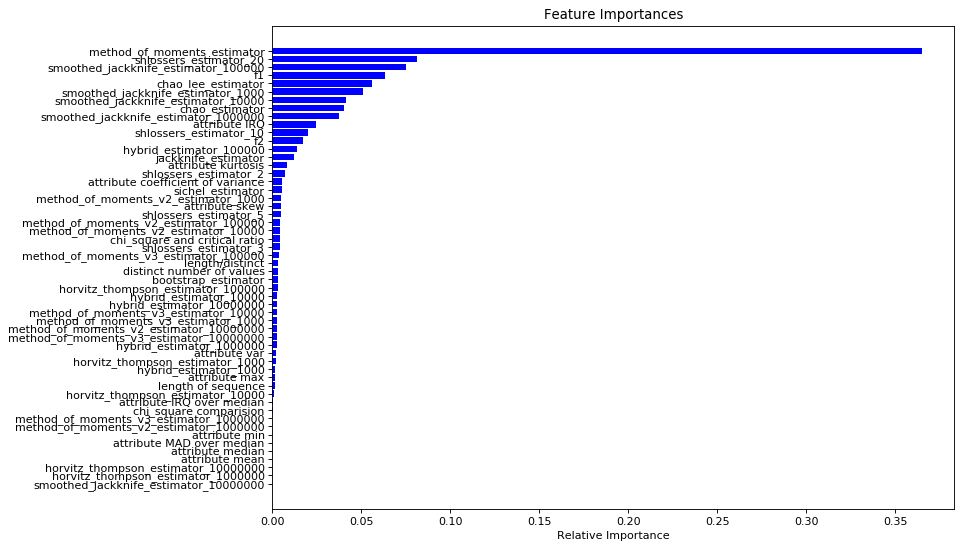

In [144]:
for name, importance in zip(feature_names, best_svr.feature_importances_):
    print(name, "=", importance)
    
features = feature_names
importances = best_svr.feature_importances_
indices = np.argsort(importances)
from matplotlib.pyplot import figure
figure(num=None, figsize=(11, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

(array([  16.,   26.,   38.,   49.,   65.,   77.,   93.,  104.,  119.,
         129.,  139.,  155.,  167.,  177.,  194.,  201.,  216.,  224.,
         234.,  242.,  260.,  275.,  287.,  298.,  309.,  323.,  336.,
         348.,  357.,  369.,  383.,  391.,  403.,  411.,  425.,  435.,
         449.,  458.,  472.,  483.,  492.,  509.,  522.,  535.,  544.,
         560.,  577.,  595.,  609.,  628.,  644.,  658.,  672.,  686.,
         695.,  716.,  722.,  734.,  746.,  750.,  763.,  775.,  785.,
         793.,  799.,  810.,  819.,  825.,  835.,  841.,  854.,  866.,
         879.,  889.,  896.,  908.,  914.,  922.,  939.,  946.,  962.,
         971.,  980.,  991.,  996., 1006., 1017., 1029., 1042., 1050.,
        1063., 1072., 1084., 1095., 1100., 1111., 1128., 1136., 1147.,
        1151., 1158., 1164., 1177., 1182., 1188., 1196., 1209., 1218.,
        1229., 1238., 1246., 1252., 1258., 1267., 1276., 1287., 1298.,
        1305., 1314., 1325., 1333., 1337., 1347., 1354., 1362., 1372.,
      

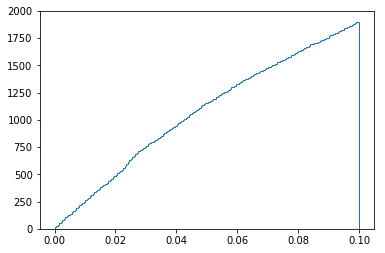

In [172]:
small_errors = list(filter(lambda x : x, [abs(i) if abs(i) < 0.1 else None for i in errors]))
plt.hist(small_errors,bins=200,cumulative=True,histtype="step")

In [175]:
np.median(abs_errors)

0.21651100500764237

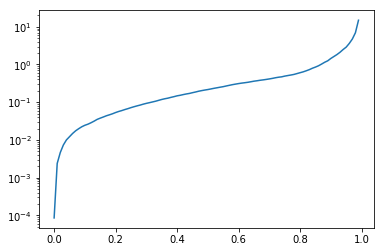

In [179]:
x = []
y = [] 
for i in range(100):
    x.append(i/100)
    y.append(np.percentile(abs_errors,i))
plt.plot(x,y)
plt.yscale("log")

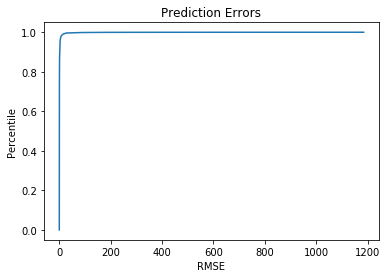

In [146]:
sortedtime = np.sort(np.abs(errors))
p = 1. * np.arange(len(errors))/(len(errors) - 1)
plt.plot(sortedtime, p)
plt.xlabel("RMSE")
plt.ylabel("Percentile")
plt.title("Prediction Errors")
plt.show()

C:\Users\User\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


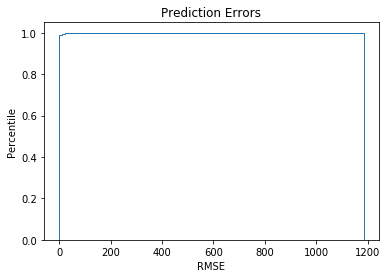

In [147]:
plt.hist(np.abs(errors),bins=100,normed=True, cumulative=True, label='CDF',
         histtype='step')
plt.xlabel("RMSE")
plt.ylabel("Percentile")
plt.title("Prediction Errors")
plt.show()

In [119]:
i = 0 
results = []
for example in zip(X_train,y_train):
    results.append({"length":example[0][0],"array":example[0],"estimate" :best_svr.predict([example[0]])[0],"Sample Distinct":example[0][1], "Population Distinct":example[1]})
    i += 1 
    if i == 100 :
        break

C:\Users\User\Anaconda3\lib\site-packages\xgboost\core.py:391: DeprecationWarning: Initializing DMatrix from List is deprecated.
  DeprecationWarning)


In [120]:
import pandas as pd
pd.set_option("display.max_colwidth",1000)
pd.DataFrame(results)

,Population Distinct,Sample Distinct,array,estimate,length
0,1297,1297.0,"[2477.0, 1297.0, 1.9097918272937549, 1.0, 12.814358876590381, 1.9097918272937549, 1.0, 272.0, 1.0, 84.35809224656387, 22.72125808669625, 609.1357972031851, 0.0, 0.0, 0.0, 44.17135472095008, 1142.0, 63.0, 11647.507936507936, 2444.2791663605435, 2438.5389584175045, 241256703.9679261, 1727.430902580761, 1683.6419930553714, 2386.886293678531, 3407.264797150466, 5335.315347264763, 9816.43031687127, 18112.78526743849, 1972.6772367984806, 1682.159919681715, 1666.55341882489, 2403.653090012458, 623518.6441141873, 1973.1633932848613, 0.0, 1681.5646906461502, 2405.433220730654, 6006661.633152296, 1973.2130831370368, 1683.2412137667604, 1683.0782209883403, 2405.617639199847, 59824189.45117781, 1973.221133285314, 1683.2445600710798, 1683.2282591256348, 2405.636145293308, 597998043.1924651, 1973.1741347929576, 0.0, 1683.346204337799, 2405.6379965453107, 5979736437.852312]",2234.140869,2477.0
1,6727,499.0,"[519.0, 499.0, 1.0400801603206413, 0.0, 0.03876387836382147, 1.0400801603206413, 1.0, 2.0, 1.0, 0.03847374106931297, 4.689536613935824, 19.991753653444675, 0.0, 0.0, 0.0, 0.03699113062348203, 479.0, 20.0, 6235.025, 6474.967968789213, 977.0770712909539, 338343.5351627965, 677.7406211511544, 6559.890432224947, 968.4008016032064, 1431.739617666447, 2355.0078277886496, 4659.32427184466, 9265.533849129593, 780.2346039643427, 5856.664950616444, 6486.619907908255, 6386.225119838398, 6386.225119838398, 780.4359170337166, 6382.318982444374, 6536.632208097693, 6454.835256644222, 6454.835256644222, 780.4560390104074, 6530.601411086667, 6537.73181416499, 6461.777693346431, 6461.777693346431, 780.4580583190917, 6537.506627268052, 6537.506511088405, 6462.472761001575, 6462.472761001575, 780.4530426423236, 0.0, 6539.317862934794, 6462.542276016816, 6462.542276016816]",5215.923340,519.0
2,1876,1112.0,"[2818.0, 1112.0, 2.5341726618705036, 1.0, 15.923739327839904, 2.5341726618705036, 1.0, 449.0, 1.0, 245.79739338025976, 22.803756521119556, 606.9872655363442, 0.0, 0.0, 0.0, 96.99315168163551, 935.0, 78.0, 6716.00641025641, 1712.3232059598138, 2046.6682044002198, 107299519.69718455, 1468.4296537776152, 1239.663467223208, 1989.8140875879785, 2798.8419013465973, 4307.658235587728, 7746.69720806592, 13949.191179132125, 1669.8133620611848, 1239.115414303123, 1223.8106775980548, 1662.8837626931893, 402562.80685360875, 1670.2163473419416, 1239.4595808028876, 1237.893950611293, 1663.5827644046958, 3725801.885889936, 1670.2561898390263, 1239.4840982247906, 1239.328399377391, 1663.6566429547504, 36932170.56469839, 1670.2562862487055, 1239.4893834903146, 1239.4737027663432, 1663.6640706901892, 368993233.2574841, 1670.2033447357876, 0.0, 1239.506247709594, 1663.6648138626524, 3689603597.8658686]",1846.173828,2818.0
3,8053,2369.0,"[2786.0, 2369.0, 1.1760236386661038, 0.0, 0.11539717216854628, 1.1760236386661038, 1.0, 4.0, 1.0, 0.1779646022271991, 2.4033419773288696, 5.7083803838468565, 0.0, 0.0, 0.0, 0.15132740225277627, 1989.0, 345.0, 8102.508695652174, 8281.474266252299, 4357.286073222748, 0.0, 3148.914865864923, 8352.819489198997, 4198.062400678038, 5930.749165120595, 9344.972630552325, 17824.342311004883, 34748.46559573234, 3580.9595064389846, 0.0, 8338.665057242446, 8258.002773596243, 8258.002773596243, 3581.8422288882493, 8340.253820722779, 8348.621103022895, 8276.536276943403, 8276.536276943403, 3581.9294012631995, 8349.825042253715, 8350.483200752727, 8278.394481912885, 8278.394481912885, 3581.9754576614164, 8350.689603621891, 8350.68907129393, 8278.58035108717, 8278.58035108717, 3581.8364188794976, 0.0, 8353.74739420738, 8278.598938491503, 8278.598938491503]",7735.682617,2786.0
4,210,210.0,"[1607.0, 210.0, 7.652380952380953, 0.0, 0.07604080934101175, 7.652380952380953, 7.0, 27.0, 1.0, 31.760113378684807, 0.6058754298544197, -0.46070434396236415, 9.75, 1.3928571428571428, 1.0590015846468586, 4.150357068776484, 33.0, 21.0, 235.92857142857142, 214.48981053574943, 242.97946484129744, 234.3237

In [33]:
pd.DataFrame(,columns=feature_names)

array([array([6116, 1315,  805, ..., 1988, 5692,  642]),
       array([4288, 2397, 9071, ..., 8383, 2911, 5825]),
       array([44, 37, 33, 19,  4, 21, 25, 43,  1]), ...,
       array([2, 4, 2, ..., 1, 2, 1]),
       array([                1,            275485,     8616552919069, ...,
               227255004,                 1, 18814203053293408]),
       array([ 4,  2,  1, ...,  1, 13,  5])], dtype=object)